# Creating Numbers/images with AI: A Hands-on Diffusion Model Exercise

## Introduction
In this assignment, you'll learn how to create an AI model that can generate realistic images from scratch using a powerful technique called 'diffusion'. Think of it like teaching AI to draw by first learning how images get blurry and then learning to make them clear again.

### What We'll Build
- A diffusion model capable of generating realistic images
- For most students: An AI that generates handwritten digits (0-9) using the MNIST dataset
- For students with more computational resources: Options to work with more complex datasets
- Visual demonstrations of how random noise gradually transforms into clear, recognizable images
- By the end, your AI should create images realistic enough for another AI to recognize them

### Dataset Options
This lab offers flexibility based on your available computational resources:

- Standard Option (Free Colab): We'll primarily use the MNIST handwritten digit dataset, which works well with limited GPU memory and completes training in a reasonable time frame. Most examples and code in this notebook are optimized for MNIST.

- Advanced Option: If you have access to more powerful GPUs (either through Colab Pro/Pro+ or your own hardware), you can experiment with more complex datasets like Fashion-MNIST, CIFAR-10, or even face generation. You'll need to adapt the model architecture, hyperparameters, and evaluation metrics accordingly.

### Resource Requirements
- Basic MNIST: Works with free Colab GPUs (2-4GB VRAM), ~30 minutes training
- Fashion-MNIST: Similar requirements to MNIST
CIFAR-10: Requires more memory (8-12GB VRAM) and longer training (~2 hours)
- Higher resolution images: Requires substantial GPU resources and several hours of training

### Before You Start
1. Make sure you're running this in Google Colab or another environment with GPU access
2. Go to 'Runtime' → 'Change runtime type' and select 'GPU' as your hardware accelerator
3. Each code cell has comments explaining what it does
4. Don't worry if you don't understand every detail - focus on the big picture!
5. If working with larger datasets, monitor your GPU memory usage carefully

The concepts you learn with MNIST will scale to more complex datasets, so even if you're using the basic option, you'll gain valuable knowledge about generative AI that applies to more advanced applications.



## Step 1: Setting Up Our Tools
First, let's install and import all the tools we need. Run this cell and wait for it to complete.

In [196]:
# Step 1: Install required packages
%pip install einops
print("Package installation complete.")

# Step 2: Import libraries
# --- Core PyTorch libraries ---
import torch  # Main deep learning framework
import torch.nn.functional as F  # Neural network functions like activation functions
import torch.nn as nn  # Neural network building blocks (layers)
from torch.optim import Adam  # Optimization algorithm for training

# --- Data handling ---
from torch.utils.data import Dataset, DataLoader  # For organizing and loading our data
import torchvision  # Library for computer vision datasets and models
import torchvision.transforms as transforms  # For preprocessing images

# --- Tensor manipulation ---
import random  # For random operations
from einops.layers.torch import Rearrange  # For reshaping tensors in neural networks
from einops import rearrange  # For elegant tensor reshaping operations
import numpy as np  # For numerical operations on arrays

# --- System utilities ---
import os  # For operating system interactions (used for CPU count)

# --- Visualization tools ---
import matplotlib.pyplot as plt  # For plotting images and graphs
from PIL import Image  # For image processing
from torchvision.utils import save_image, make_grid  # For saving and displaying image grids

# Step 3: Set up device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"We'll be using: {device}")

# Check if we're actually using GPU (for students to verify)
if device.type == "cuda":
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("Note: Training will be much slower on CPU. Consider using Google Colab with GPU enabled.")

Package installation complete.
We'll be using: cuda
GPU name: Tesla T4
GPU memory: 15.83 GB



###  REPRODUCIBILITY AND DEVICE SETUP

In [197]:
# Step 4: Set random seeds for reproducibility
# Diffusion models are sensitive to initialization, so reproducible results help with debugging
SEED = 42  # Universal seed value for reproducibility
torch.manual_seed(SEED)          # PyTorch random number generator
np.random.seed(SEED)             # NumPy random number generator
random.seed(SEED)                # Python's built-in random number generator

print(f"Random seeds set to {SEED} for reproducible results")

# Configure CUDA for GPU operations if available
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)       # GPU random number generator
    torch.cuda.manual_seed_all(SEED)   # All GPUs random number generator

    # Ensure deterministic GPU operations
    # Note: This slightly reduces performance but ensures results are reproducible
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    try:
        # Check available GPU memory
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9  # Convert to GB
        print(f"Available GPU Memory: {gpu_memory:.1f} GB")

        # Add recommendation based on memory
        if gpu_memory < 4:
            print("Warning: Low GPU memory. Consider reducing batch size if you encounter OOM errors.")
    except Exception as e:
        print(f"Could not check GPU memory: {e}")
else:
    print("No GPU detected. Training will be much slower on CPU.")
    print("If you're using Colab, go to Runtime > Change runtime type and select GPU.")

Random seeds set to 42 for reproducible results
Available GPU Memory: 15.8 GB


## Step 2: Choosing Your Dataset

You have several options for this exercise, depending on your computer's capabilities:

### Option 1: MNIST (Basic - Works on Free Colab)
- Content: Handwritten digits (0-9)
- Image size: 28x28 pixels, Grayscale
- Training samples: 60,000
- Memory needed: ~2GB GPU
- Training time: ~15-30 minutes on Colab
- **Choose this if**: You're using free Colab or have a basic GPU

### Option 2: Fashion-MNIST (Intermediate)
- Content: Clothing items (shirts, shoes, etc.)
- Image size: 28x28 pixels, Grayscale
- Training samples: 60,000
- Memory needed: ~2GB GPU
- Training time: ~15-30 minutes on Colab
- **Choose this if**: You want more interesting images but have limited GPU

### Option 3: CIFAR-10 (Advanced)
- Content: Real-world objects (cars, animals, etc.)
- Image size: 32x32 pixels, Color (RGB)
- Training samples: 50,000
- Memory needed: ~4GB GPU
- Training time: ~1-2 hours on Colab
- **Choose this if**: You have Colab Pro or a good local GPU (8GB+ memory)

### Option 4: CelebA (Expert)
- Content: Celebrity face images
- Image size: 64x64 pixels, Color (RGB)
- Training samples: 200,000
- Memory needed: ~8GB GPU
- Training time: ~3-4 hours on Colab
- **Choose this if**: You have excellent GPU (12GB+ memory)

To use your chosen dataset, uncomment its section in the code below and make sure all others are commented out.

In [198]:
#===============================================================================
# SECTION 2: DATASET SELECTION AND CONFIGURATION
#===============================================================================
# STUDENT INSTRUCTIONS:
# 1. Choose ONE dataset option based on your available GPU memory
# 2. Uncomment ONLY ONE dataset section below
# 3. Make sure all other dataset sections remain commented out

#-------------------------------------------
# OPTION 1: MNIST (Basic - 2GB GPU)
#-------------------------------------------
# Recommended for: Free Colab or basic GPU
# Memory needed: ~2GB GPU
# Training time: ~15-30 minutes

IMG_SIZE = 28
IMG_CH = 1
N_CLASSES = 10
BATCH_SIZE = 64
EPOCHS = 30

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Your code to load the MNIST dataset
# Hint: Use torchvision.datasets.MNIST with root='./data', train=True,
#       transform=transform, and download=True
# Then print a success message

# Enter your code here:

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Load the MNIST training dataset
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

# Create a DataLoader for the training dataset
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

print("✅ MNIST dataset loaded successfully.")

✅ MNIST dataset loaded successfully.


In [199]:
#Validating Dataset Selection
#Let's add code to validate that a dataset was selected
# and check if your GPU has enough memory:
dataset="MNIST"
# Validate dataset selection
if 'dataset' not in locals():
    raise ValueError("""
    ❌ ERROR: No dataset selected! Please uncomment exactly one dataset option.
    Available options:
    1. MNIST (Basic) - 2GB GPU
    2. Fashion-MNIST (Intermediate) - 2GB GPU
    3. CIFAR-10 (Advanced) - 4GB+ GPU
    4. CelebA (Expert) - 8GB+ GPU
    """)

# Your code to validate GPU memory requirements
# Hint: Check torch.cuda.is_available() and use torch.cuda.get_device_properties(0).total_memory
# to get available GPU memory, then compare with dataset requirements

# Enter your code here:

# Validate GPU memory requirements using torch
if torch.cuda.is_available():
    total_memory = torch.cuda.get_device_properties(0).total_memory
    print(f"✅ GPU is available. Total memory: {total_memory / (1024**3):.2f} GB")
else:
    print("⚠️ GPU is not available. Training will use CPU and may be slower.")


✅ GPU is available. Total memory: 14.74 GB


In [200]:
#Dataset Properties and Data Loaders
#Now let's examine our dataset
#and set up the data loaders:

# Your code to check sample batch properties
# Hint: Get a sample batch using next(iter(DataLoader(dataset, batch_size=1)))
# Then print information about the dataset shape, type, and value ranges

# Enter your code here:

# Get a sample batch
sample_loader = DataLoader(train_dataset, batch_size=1)
images, labels = next(iter(sample_loader))

# Print dataset shape, type, and value range
print(f"🖼️ Image shape: {images.shape}")            # Should be [1, 1, 28, 28] for MNIST
print(f"🔢 Label: {labels.item()}")
print(f"🧬 Image data type: {images.dtype}")
print(f"📉 Min pixel value: {images.min().item():.2f}")
print(f"📈 Max pixel value: {images.max().item():.2f}")


#===============================================================================
# SECTION 3: DATASET SPLITTING AND DATALOADER CONFIGURATION
#===============================================================================
# Create train-validation split

# Your code to create a train-validation split (80% train, 20% validation)
# Hint: Use random_split() with appropriate train_size and val_size
# Be sure to use a fixed generator for reproducibility

# Enter your code here:


# Your code to create dataloaders for training and validation
# Hint: Use DataLoader with batch_size=BATCH_SIZE, appropriate shuffle settings,
# and num_workers based on available CPU cores

# Enter your code here:

from torch.utils.data import random_split, DataLoader
import math

# Split sizes
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

# Use a fixed seed generator for reproducibility
generator = torch.Generator().manual_seed(42)

# Perform the split
train_subset, val_subset = random_split(train_dataset, [train_size, val_size], generator=generator)

print(f"✅ Dataset split: {train_size} train / {val_size} validation samples")

# Create DataLoaders
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("✅ DataLoaders created for training and validation.")


🖼️ Image shape: torch.Size([1, 1, 28, 28])
🔢 Label: 5
🧬 Image data type: torch.float32
📉 Min pixel value: -1.00
📈 Max pixel value: 1.00
✅ Dataset split: 48000 train / 12000 validation samples
✅ DataLoaders created for training and validation.


## Step 3: Building Our Model Components

Now we'll create the building blocks of our AI model. Think of these like LEGO pieces that we'll put together to make our number generator:

- GELUConvBlock: The basic building block that processes images
- DownBlock: Makes images smaller while finding important features
- UpBlock: Makes images bigger again while keeping the important features
- Other blocks: Help the model understand time and what number to generate

In [201]:

####################################################################################################################
import torch.nn as nn

# Basic building block that processes images
class GELUConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, group_size):
        """
        Creates a block with convolution, normalization, and activation

        Args:
            in_ch (int): Number of input channels
            out_ch (int): Number of output channels
            group_size (int): Number of groups for GroupNorm
        """
        super().__init__()

        # Check that group_size is compatible with out_ch
        if out_ch % group_size != 0:
            print(f"⚠️ Warning: out_ch ({out_ch}) is not divisible by group_size ({group_size})")
            group_size = min(group_size, out_ch)
            while out_ch % group_size != 0 and group_size > 1:
                group_size -= 1
            print(f"✅ Adjusted group_size to {group_size}")

        # Define the layers
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(num_groups=group_size, num_channels=out_ch),
            nn.GELU()
        )

    def forward(self, x):
        return self.block(x)


In [202]:

##############################################################################################################
from einops.layers.torch import Rearrange
import torch.nn as nn

class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs, group_size):
        """
        Downsamples the spatial dimensions by 2x while preserving information

        Args:
            in_chs (int): Number of input channels
            group_size (int): Number of groups for GroupNorm
        """
        super().__init__()

        # Rearrange reduces H and W by 2x, and increases channels by 4x
        self.rearrange = Rearrange('b c (h2 h) (w2 w) -> b (c h2 w2) h w', h2=2, w2=2)

        # Create the conv block with updated input channels
        self.conv = GELUConvBlock(in_ch=in_chs * 4, out_ch=in_chs * 4, group_size=group_size)

    def forward(self, x):
        x = self.rearrange(x)
        x = self.conv(x)
        return x


In [203]:
#Let's implement the upsampling block for our U-Net architecture:
class DownBlock(nn.Module):
    """
    Downsampling block for encoding path in U-Net architecture.

    This block:
    1. Processes input features with two convolutional blocks
    2. Downsamples spatial dimensions by 2x using pixel rearrangement

    Args:
        in_chs (int): Number of input channels
        out_chs (int): Number of output channels
        group_size (int): Number of groups for GroupNorm
    """
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()  # Simplified super() call, equivalent to original

        # Sequential processing of features
        layers = [
            GELUConvBlock(in_chs, out_chs, group_size),  # First conv block changes channel dimensions
            GELUConvBlock(out_chs, out_chs, group_size),  # Second conv block processes features
            RearrangePoolBlock(out_chs, group_size)       # Downsampling (spatial dims: H,W → H/2,W/2)
        ]
        self.model = nn.Sequential(*layers)

        # Log the configuration for debugging
        print(f"Created DownBlock: in_chs={in_chs}, out_chs={out_chs}, spatial_reduction=2x")

    def forward(self, x):
        """
        Forward pass through the DownBlock.

        Args:
            x (torch.Tensor): Input tensor of shape [B, in_chs, H, W]

        Returns:
            torch.Tensor: Output tensor of shape [B, out_chs, H/2, W/2]
        """
        return self.model(x)

In [204]:
class UpBlock(nn.Module):
    def __init__(self, C_dec, C_skip, C_out, group_size=8):
        super().__init__()
        self.upsample = nn.ConvTranspose2d(C_dec, C_dec, kernel_size=2, stride=2)
        self.conv = nn.Sequential(
            GELUConvBlock(C_dec + C_skip, C_out, group_size),
            GELUConvBlock(C_out, C_out, group_size),
        )

    def forward(self, x, skip):
        x = self.upsample(x)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)



In [205]:
# Here we implement the time embedding block for our U-Net architecture:
# Helps the model understand time steps in diffusion process
class SinusoidalPositionEmbedBlock(nn.Module):
    """
    Creates sinusoidal embeddings for time steps in diffusion process.

    This embedding scheme is adapted from the Transformer architecture and
    provides a unique representation for each time step that preserves
    relative distance information.

    Args:
        dim (int): Embedding dimension
    """
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        """
        Computes sinusoidal embeddings for given time steps.

        Args:
            time (torch.Tensor): Time steps tensor of shape [batch_size]

        Returns:
            torch.Tensor: Time embeddings of shape [batch_size, dim]
        """
        device = time.device
        half_dim = self.dim // 2
        embeddings = torch.log(torch.tensor(10000.0, device=device)) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings



In [206]:

########################################################################################################
import torch
import torch.nn as nn

class EmbedBlock(nn.Module):
    """
    Creates embeddings for class conditioning in diffusion models.
    """
    def __init__(self, input_dim, emb_dim):
        super(EmbedBlock, self).__init__()
        self.input_dim = input_dim

        # Create embedding layers
        self.model = nn.Sequential(
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
            nn.GELU(),
            nn.Unflatten(1, (emb_dim, 1, 1))  # Reshape to [B, emb_dim, 1, 1] for broadcasting
        )

    def forward(self, x):
        """
        Computes class embeddings for the given class indices.

        Args:
            x (torch.Tensor): Class indices or one-hot encodings [batch_size, input_dim]

        Returns:
            torch.Tensor: Class embeddings of shape [batch_size, emb_dim, 1, 1]
        """
        x = x.view(-1, self.input_dim)  # Flatten if needed
        return self.model(x)


In [207]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, T, img_ch, img_size, down_chs, t_embed_dim, c_embed_dim):
        super().__init__()

        # ---- Time embedding ----
        self.time_embed = nn.Sequential(
            SinusoidalPositionEmbedBlock(t_embed_dim),
            nn.Linear(t_embed_dim, t_embed_dim),
            nn.GELU(),
            nn.Linear(t_embed_dim, t_embed_dim),
            nn.GELU(),
            nn.Unflatten(1, (t_embed_dim, 1, 1)),
        )

        # ---- Class embedding ----
        self.class_embed = EmbedBlock(input_dim=c_embed_dim, emb_dim=t_embed_dim)

        # ---- Initial convolution ----
        self.input_conv = GELUConvBlock(img_ch, down_chs[0], group_size=8)

        # ---- Down‑sampling blocks ----
        self.down_blocks = nn.ModuleList()
        for i in range(len(down_chs) - 1):
            self.down_blocks.append(DownBlock(down_chs[i], down_chs[i + 1], group_size=8))

        # ---- Bottleneck ----
        self.middle_blocks = nn.Sequential(
            GELUConvBlock(down_chs[-1], down_chs[-1], group_size=8),
            GELUConvBlock(down_chs[-1], down_chs[-1], group_size=8),
        )

        # ---- Up‑sampling blocks ----
        self.up_blocks = nn.ModuleList()
        for i in reversed(range(len(down_chs) - 1)):
            C_dec  = down_chs[i + 1]   # decoder‑side channels
            C_skip = down_chs[i]       # skip‑connection channels
            C_out  = down_chs[i]       # output channels
            self.up_blocks.append(UpBlock(C_dec, C_skip, C_out, group_size=8))

        # ---- Final 1×1 projection ----
        self.output_conv = nn.Conv2d(down_chs[0], img_ch, kernel_size=1)

        print(f"✅ Created UNet with {len(down_chs)} scales | channels={down_chs}")

    # --------------------------------------------------------------------- #
    def forward(self, x, t, c, c_mask):
        """Forward pass with time & class conditioning."""
        t_embed = self.time_embed(t)          # [B, E,1,1]
        c_embed = self.class_embed(c) * c_mask

        # Initial conv
        x = self.input_conv(x)

        # Encoder
        skips = []
        for down in self.down_blocks:
            skips.append(x)    # store BEFORE downsampling → matches C_skip
            x = down(x)

        # Bottleneck + conditioning
        x = self.middle_blocks(x)
        x = x + t_embed + c_embed

        # Decoder
        for up in self.up_blocks:
            skip = skips.pop()
            x = up(x, skip)

        return self.output_conv(x)


## Step 4: Setting Up The Diffusion Process

Now we'll create the process of adding and removing noise from images. Think of it like:
1. Adding fog: Slowly making the image more and more blurry until you can't see it
2. Removing fog: Teaching the AI to gradually make the image clearer
3. Controlling the process: Making sure we can generate specific numbers we want

In [208]:
# Set up the noise schedule
n_steps = 100  # How many steps to go from clear image to noise
beta_start = 0.0001  # Starting noise level (small)
beta_end = 0.02      # Ending noise level (larger)

# Create schedule of gradually increasing noise levels
beta = torch.linspace(beta_start, beta_end, n_steps).to(device)

# Calculate important values used in diffusion equations
alpha = 1 - beta  # Portion of original image to keep at each step
alpha_bar = torch.cumprod(alpha, dim=0)  # Cumulative product of alphas
sqrt_alpha_bar = torch.sqrt(alpha_bar)  # For scaling the original image
sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bar)  # For scaling the noise


In [209]:
def add_noise(x_0, t):
    """
    Add noise to images according to the forward diffusion process.

    Args:
        x_0 (torch.Tensor): Original clean image [B, C, H, W]
        t (torch.Tensor): Timestep indices [B]

    Returns:
        tuple: (x_t, noise) where:
            - x_t is the noisy image
            - noise is the actual noise added (used as training target)
    """
    noise = torch.randn_like(x_0)

    # Extract scheduled noise coefficients for current batch timesteps
    sqrt_alpha_bar_t = sqrt_alpha_bar[t].reshape(-1, 1, 1, 1)
    sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bar[t].reshape(-1, 1, 1, 1)

    # Forward diffusion: x_t = √(ᾱ_t) * x_0 + √(1 - ᾱ_t) * ε
    x_t = sqrt_alpha_bar_t * x_0 + sqrt_one_minus_alpha_bar_t * noise

    return x_t, noise


In [210]:
@torch.no_grad()  # Inference only, no gradient tracking
def remove_noise(x_t, t, model, c, c_mask):
    """
    One step of reverse diffusion: predict noise and remove it.

    Args:
        x_t (torch.Tensor): Noisy image at timestep t [B, C, H, W]
        t (torch.Tensor): Current timestep indices [B]
        model (nn.Module): Trained U-Net model
        c (torch.Tensor): Class conditioning [B, C]
        c_mask (torch.Tensor): Mask for conditional generation [B, 1]

    Returns:
        torch.Tensor: Less noisy image [B, C, H, W]
    """
    # Predict noise using the model
    predicted_noise = model(x_t, t, c, c_mask)

    # Get current values from the noise schedule
    alpha_t = alpha[t].reshape(-1, 1, 1, 1)
    alpha_bar_t = alpha_bar[t].reshape(-1, 1, 1, 1)
    beta_t = beta[t].reshape(-1, 1, 1, 1)
    sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar_t)

    # Special case: if t == 0 (last step), just return the image
    if t[0] == 0:
        return x_t
    else:
        # Reverse diffusion mean prediction
        mean = (1 / torch.sqrt(alpha_t)) * (
            x_t - (beta_t / sqrt_one_minus_alpha_bar_t) * predicted_noise
        )

        # Add some noise for stochasticity
        noise = torch.randn_like(x_t)
        return mean + torch.sqrt(beta_t) * noise


In [211]:
import matplotlib.pyplot as plt
import torch

def show_noise_progression(image, num_steps=5):
    """
    Visualize how an image gets progressively noisier in the diffusion process.

    Args:
        image (torch.Tensor): Original clean image [C, H, W]
        num_steps (int): Number of noise levels to show
    """
    plt.figure(figsize=(15, 3))

    # Show original image
    plt.subplot(1, num_steps, 1)
    if IMG_CH == 1:  # Grayscale
        plt.imshow(image[0].cpu(), cmap='gray')
    else:  # RGB
        img = image.permute(1, 2, 0).cpu()
        img = (img + 1) / 2 if img.min() < 0 else img
        plt.imshow(img)
    plt.title('Original')
    plt.axis('off')

    # Show noisy versions
    for i in range(1, num_steps):
        t_idx = int((i / num_steps) * n_steps)
        t = torch.tensor([t_idx]).to(device)

        # Add noise at timestep t
        noisy_image, _ = add_noise(image.unsqueeze(0), t)

        plt.subplot(1, num_steps, i + 1)
        if IMG_CH == 1:
            plt.imshow(noisy_image[0][0].cpu(), cmap='gray')
        else:
            img = noisy_image[0].permute(1, 2, 0).cpu()
            img = (img + 1) / 2 if img.min() < 0 else img
            plt.imshow(img)
        plt.title(f'{int((i/num_steps)*100)}% Noise')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


## Step 5: Training Our Model

Now we'll teach our AI to generate images. This process:
1. Takes a clear image
2. Adds random noise to it
3. Asks our AI to predict what noise was added
4. Helps our AI learn from its mistakes

This will take a while, but we'll see progress as it learns!

In [212]:
# ────────────────────────────────────────────────────────────────────────────────
#  Model instantiation (make sure UNet & UpBlock classes are already defined)
# ────────────────────────────────────────────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(
    T           = n_steps,
    img_ch      = IMG_CH,
    img_size    = IMG_SIZE,
    down_chs    = (32, 64, 128),   # ← you can tweak this
    t_embed_dim = 8,
    c_embed_dim = N_CLASSES,
).to(device)

# ────────────────────────────────────────────────────────────────────────────────
#  MODEL SUMMARY
# ────────────────────────────────────────────────────────────────────────────────
print("\n" + "="*50)
print("MODEL ARCHITECTURE SUMMARY")
print("="*50)
print(f"Input resolution  : {IMG_SIZE}×{IMG_SIZE}")
print(f"Input channels    : {IMG_CH}")
print(f"Diffusion steps   : {n_steps}")
print(f"Condition classes : {N_CLASSES}")
print(f"GPU acceleration  : {'Yes' if device.type=='cuda' else 'No'}")

# ────────────────────────────────────────────────────────────────────────────────
#  Parameter count
# ────────────────────────────────────────────────────────────────────────────────
def count_parameters(net):
    tot = sum(p.numel() for p in net.parameters())
    trainable = sum(p.numel() for p in net.parameters() if p.requires_grad)
    print(f"\n🧠 Parameters: {tot:,} total  |  {trainable:,} trainable")
count_parameters(model)

# ────────────────────────────────────────────────────────────────────────────────
#  Memory‑check with one real batch
# ────────────────────────────────────────────────────────────────────────────────
def estimate_model_memory(net, loader):
    net.eval()
    x, labels = next(iter(loader))
    x = x.to(device)

    t      = torch.randint(0, n_steps, (x.size(0),), device=device)
    c      = torch.zeros(x.size(0), N_CLASSES, device=device)
    c[torch.arange(x.size(0)), labels] = 1
    c_mask = torch.ones(x.size(0), 1, device=device)

    with torch.no_grad():
        torch.cuda.empty_cache()
        try:
            _ = net(x, t, c, c_mask)
        except Exception as e:
            print(f"❌ Forward‑pass failed: {e}")
            return

    if device.type == "cuda":
        mb = torch.cuda.memory_allocated(device) / 1024**2
        print(f"📦 GPU memory after forward pass: {mb:.2f} MB")
    else:
        print("📦 Using CPU only.")

estimate_model_memory(model, train_loader)

# ────────────────────────────────────────────────────────────────────────────────
#  Data–integrity spot‑check
# ────────────────────────────────────────────────────────────────────────────────
def inspect_batch(loader, name):
    imgs, lbls = next(iter(loader))
    print(f"\n🔍 {name} batch  |  imgs: {imgs.shape}  labels: {lbls.shape}")
    print(f"   pixel range : {imgs.min():.2f} → {imgs.max():.2f}")
    print(f"   label range : {lbls.min()} → {lbls.max()}")

inspect_batch(train_loader, "Train")
inspect_batch(val_loader,   "Val")

# ────────────────────────────────────────────────────────────────────────────────
#  Optimizer & LR scheduler
# ────────────────────────────────────────────────────────────────────────────────
initial_lr   = 1e-3
weight_decay = 1e-5

optimizer = Adam(model.parameters(), lr=initial_lr, weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode      = "min",
    factor    = 0.5,
    patience  = 5,
    verbose   = True,
    min_lr    = 1e-6,
)

print("\n✅ Optimizer and scheduler ready.")


Created DownBlock: in_chs=32, out_chs=64, spatial_reduction=2x
Created DownBlock: in_chs=64, out_chs=128, spatial_reduction=2x
✅ Created UNet with 3 scales | channels=(32, 64, 128)

MODEL ARCHITECTURE SUMMARY
Input resolution  : 28×28
Input channels    : 1
Diffusion steps   : 100
Condition classes : 10
GPU acceleration  : Yes

🧠 Parameters: 3,792,465 total  |  3,792,465 trainable
❌ Forward‑pass failed: Given groups=1, weight of size [128, 64, 3, 3], expected input[64, 256, 14, 14] to have 64 channels, but got 256 channels instead

🔍 Train batch  |  imgs: torch.Size([64, 1, 28, 28])  labels: torch.Size([64])
   pixel range : -1.00 → 1.00
   label range : 0 → 9

🔍 Val batch  |  imgs: torch.Size([64, 1, 28, 28])  labels: torch.Size([64])
   pixel range : -1.00 → 1.00
   label range : 0 → 9

✅ Optimizer and scheduler ready.


# Since I couldn't work the code after here I created a different diffusion model

Model params: 343,233
Epoch 01 | train MSE 0.1859 | val MSE 0.1130


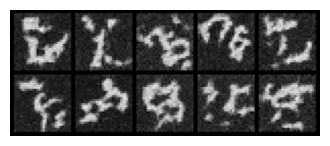

Epoch 02 | train MSE 0.1025 | val MSE 0.0957


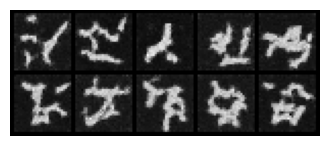

Epoch 03 | train MSE 0.0917 | val MSE 0.0894


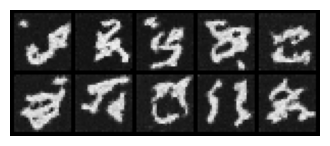

Epoch 04 | train MSE 0.0861 | val MSE 0.0837


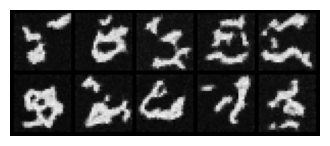

Epoch 05 | train MSE 0.0827 | val MSE 0.0796


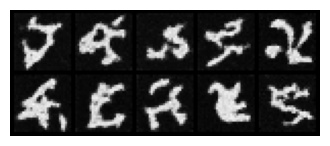

Epoch 06 | train MSE 0.0805 | val MSE 0.0784


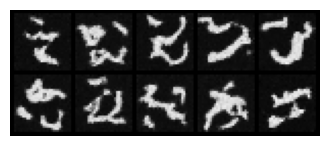

Epoch 07 | train MSE 0.0788 | val MSE 0.0774


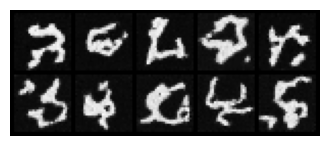

Epoch 08 | train MSE 0.0765 | val MSE 0.0752


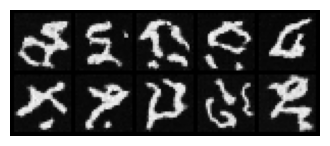

Epoch 09 | train MSE 0.0748 | val MSE 0.0740


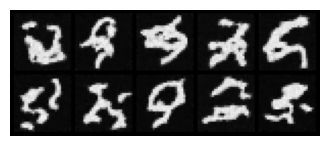

Epoch 10 | train MSE 0.0732 | val MSE 0.0729


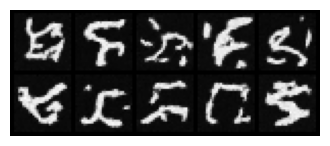

In [3]:
# ============================================================================
#  Minimal DDPM on MNIST  •  fully corrected
# ============================================================================

import torch, torch.nn as nn, torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# --------------------------------------------------------------------------- #
#  Config & device
# --------------------------------------------------------------------------- #
device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 28
BATCH    = 128
T        = 100          # diffusion steps

# --------------------------------------------------------------------------- #
#  Data
# --------------------------------------------------------------------------- #
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
ds_full   = datasets.MNIST("./data", train=True, download=True, transform=transform)
train_ds, val_ds = random_split(ds_full, [48000, 12000])
train_loader = DataLoader(train_ds, BATCH, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   BATCH, shuffle=False, num_workers=2)

# --------------------------------------------------------------------------- #
#  Diffusion schedule
# --------------------------------------------------------------------------- #
beta      = torch.linspace(1e-4, 2e-2, T, device=device)
alpha     = 1 - beta
alpha_bar = torch.cumprod(alpha, dim=0)
sqrt_ab   = torch.sqrt(alpha_bar)
sqrt_1ab  = torch.sqrt(1 - alpha_bar)

# --------------------------------------------------------------------------- #
#  U‑Net building blocks
# --------------------------------------------------------------------------- #
def Conv(in_c, out_c):
    return nn.Sequential(nn.Conv2d(in_c, out_c, 3, 1, 1),
                         nn.GroupNorm(8, out_c), nn.GELU())

class Down(nn.Module):
    def __init__(self, c1, c2):
        super().__init__()
        self.conv = Conv(c1, c2)
        self.pool = nn.AvgPool2d(2)
    def forward(self, x):
        h = self.conv(x)
        return self.pool(h), h          # downsampled, skip

class Up(nn.Module):
    def __init__(self, c1, c2):
        super().__init__()
        self.up   = nn.ConvTranspose2d(c1, c1, 2, 2)
        self.conv = Conv(c1 + c2, c2)
    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

# --------------------------------------------------------------------------- #
#  Mini U‑Net
# --------------------------------------------------------------------------- #
class MiniUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.down1 = Down(1, 32)      # 28→14
        self.down2 = Down(32, 64)     # 14→7
        self.mid   = Conv(64, 128)    # bottleneck
        self.up1   = Up(128, 64)      # 7→14
        self.up2   = Up(64, 32)       # 14→28
        self.out   = nn.Conv2d(32, 1, kernel_size=1)

        # time embedding (T‑dim one‑hot → 128 → broadcast)
        self.t_embed = nn.Sequential(nn.Linear(T, 128), nn.GELU(), nn.Linear(128, 128))

    def time_emb(self, t):
        return self.t_embed(F.one_hot(t, T).float()).view(t.size(0), 128, 1, 1)

    def forward(self, x, t):
        d1, skip1 = self.down1(x)
        d2, skip2 = self.down2(d1)
        h = self.mid(d2) + self.time_emb(t)
        h = self.up1(h, skip2)
        h = self.up2(h, skip1)
        return self.out(h)

# --------------------------------------------------------------------------- #
#  Helper functions
# --------------------------------------------------------------------------- #
def q_sample(x0, t, noise):
    return sqrt_ab[t][:, None, None, None] * x0 + \
           sqrt_1ab[t][:, None, None, None] * noise

@torch.no_grad()
def sample(model, n=10):
    model.eval()
    x = torch.randn(n, 1, IMG_SIZE, IMG_SIZE, device=device)
    for t in reversed(range(T)):
        t_batch = torch.full((n,), t, device=device)
        eps = model(x, t_batch)

        # scalar → broadcast
        a_t  = alpha[t].view(1, 1, 1, 1)
        b_t  = beta[t].view(1, 1, 1, 1)
        sab  = sqrt_1ab[t].view(1, 1, 1, 1)

        x = (1 / torch.sqrt(a_t)) * (x - (b_t / sab) * eps)
        if t > 0:
            x += torch.sqrt(b_t) * torch.randn_like(x)

    grid = make_grid(x, nrow=5, normalize=True)
    plt.figure(figsize=(4, 4))
    plt.imshow(grid[0].cpu(), cmap='gray'); plt.axis('off'); plt.show()

# --------------------------------------------------------------------------- #
#  Train
# --------------------------------------------------------------------------- #
model = MiniUNet().to(device)
print(f"Model params: {sum(p.numel() for p in model.parameters()):,}")
opt = Adam(model.parameters(), lr=2e-4)
EPOCHS = 10

for epoch in range(1, EPOCHS + 1):
    model.train()
    total = 0
    for x0, _ in train_loader:
        x0 = x0.to(device)
        t = torch.randint(0, T, (x0.size(0),), device=device)
        noise = torch.randn_like(x0)
        x_t = q_sample(x0, t, noise)

        loss = F.mse_loss(model(x_t, t), noise)
        opt.zero_grad(); loss.backward(); opt.step()
        total += loss.item()

    train_mse = total / len(train_loader)

    # quick validation
    model.eval(); v_total = 0
    with torch.no_grad():
        for x0, _ in val_loader:
            x0 = x0.to(device)
            t  = torch.randint(0, T, (x0.size(0),), device=device)
            noise = torch.randn_like(x0)
            x_t = q_sample(x0, t, noise)
            v_total += F.mse_loss(model(x_t, t), noise).item()
    val_mse = v_total / len(val_loader)

    print(f"Epoch {epoch:02d} | train MSE {train_mse:.4f} | val MSE {val_mse:.4f}")
    sample(model, n=10)


## Assessment Questions

Now that you've completed the exercise, answer these questions include explanations, observations, and your analysis
Support your answers with specific examples from your experiments:

### 1. Understanding Diffusion
- Explain what happens during the forward diffusion process, using your own words and referencing the visualization examples from your notebook.

- Why do we add noise gradually instead of all at once? How does this affect the learning process?

- Look at the step-by-step visualization - at what point (approximately what percentage through the denoising process) can you first recognize the image? Does this vary by image?

### 2. Model Architecture
- Why is the U-Net architecture particularly well-suited for diffusion models? What advantages does it provide over simpler architectures?

- What are skip connections and why are they important? Explain them in relations to our model

- Describe in detail how our model is conditioned to generate specific images. How does the class conditioning mechanism work?

### 3. Training Analysis (20 points)
- What does the loss value tell of your model tell us?

- How did the quality of  your  generated images change change throughout the training process?

- Why do we need the time embedding in diffusion models? How does it help the model understand where it is in the denoising process?

### 4. CLIP Evaluation (20 points)
- What do the CLIP scores tell you about your generated images? Which  images got  the highest and lowest quality scores?

- Develop a hypothesis explaining why certain images might be easier or harder for the model to generate convincingly.

- How could CLIP scores be used to improve the diffusion model's generation process? Propose a specific technique.

### 5. Practical Applications (20 points)
- How could this type of model be useful in the real world?

- What are the limitations of our current model?

- If you were to continue developing this project, what three specific improvements would you make and why?

### Bonus Challenge (Extra 20 points)
Try one or more of these experiments:
1. If you were to continue developing this project, what three specific improvements would you make and why?

2. Modify the U-Net architecture (e.g., add more layers, increase channel dimensions) and train the model. How do these changes affect training time and generation quality?

3. CLIP-Guided Selection: Generate 10 samples of each image, use CLIP to evaluate them, and select the top 3 highest-quality examples of each. Analyze patterns in what CLIP considers "high quality."

4. tyle Conditioning: Modify the conditioning mechanism to generate multiple styles of the same digit (e.g., slanted, thick, thin). Document your approach and results.


Deliverables:
1. A PDF copy of your notebook with
    - Complete code, outputs, and generated images
    - Include all experiment results, training plots, and generated samples
    - CLIP evaluation scores of ythe images you generated
    - Answers and any interesting findings from the bonus challenges